In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

In [19]:
df = pd.read_csv('model/student_habits_performance.csv')

In [20]:
df.head()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


In [21]:
df.shape

(1000, 16)

In [22]:
df.describe()

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,exercise_frequency,mental_health_rating,exam_score
count,1000.0000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.4980,3.55010,2.505500,1.819700,84.131700,6.470100,3.042000,5.438000,69.601500
std,2.3081,1.46889,1.172422,1.075118,9.399246,1.226377,2.025423,2.847501,16.888564
min,17.0000,0.00000,0.000000,0.000000,56.000000,3.200000,0.000000,1.000000,18.400000
25%,18.7500,2.60000,1.700000,1.000000,78.000000,5.600000,1.000000,3.000000,58.475000
50%,20.0000,3.50000,2.500000,1.800000,84.400000,6.500000,3.000000,5.000000,70.500000
75%,23.0000,4.50000,3.300000,2.525000,91.025000,7.300000,5.000000,8.000000,81.325000
max,24.0000,8.30000,7.200000,5.400000,100.000000,10.000000,6.000000,10.000000,100.000000


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   student_id                     1000 non-null   object 
 1   age                            1000 non-null   int64  
 2   gender                         1000 non-null   object 
 3   study_hours_per_day            1000 non-null   float64
 4   social_media_hours             1000 non-null   float64
 5   netflix_hours                  1000 non-null   float64
 6   part_time_job                  1000 non-null   object 
 7   attendance_percentage          1000 non-null   float64
 8   sleep_hours                    1000 non-null   float64
 9   diet_quality                   1000 non-null   object 
 10  exercise_frequency             1000 non-null   int64  
 11  parental_education_level       909 non-null    object 
 12  internet_quality               1000 non-null   ob

In [24]:
df.duplicated().any()

np.False_

In [25]:
df.isnull().sum()

student_id                        0
age                               0
gender                            0
study_hours_per_day               0
social_media_hours                0
netflix_hours                     0
part_time_job                     0
attendance_percentage             0
sleep_hours                       0
diet_quality                      0
exercise_frequency                0
parental_education_level         91
internet_quality                  0
mental_health_rating              0
extracurricular_participation     0
exam_score                        0
dtype: int64

In [26]:
df['parental_education_level'].fillna(df['parental_education_level'].mode()[0], inplace=True)

C:\Users\Asus\AppData\Local\Temp\ipykernel_25344\2922058664.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['parental_education_level'].fillna(df['parental_education_level'].mode()[0], inplace=True)


In [27]:
df.isnull().sum()

student_id                       0
age                              0
gender                           0
study_hours_per_day              0
social_media_hours               0
netflix_hours                    0
part_time_job                    0
attendance_percentage            0
sleep_hours                      0
diet_quality                     0
exercise_frequency               0
parental_education_level         0
internet_quality                 0
mental_health_rating             0
extracurricular_participation    0
exam_score                       0
dtype: int64

### Univariate Analysis

In [28]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(include='object').columns.tolist()

In [29]:
print("\n🔹 Numerical Columns:", num_cols)
print("🔹 Categorical Columns:", cat_cols)


🔹 Numerical Columns: ['age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours', 'attendance_percentage', 'sleep_hours', 'exercise_frequency', 'mental_health_rating', 'exam_score']
🔹 Categorical Columns: ['student_id', 'gender', 'part_time_job', 'diet_quality', 'parental_education_level', 'internet_quality', 'extracurricular_participation']


In [30]:
fig = px.imshow(
    df[num_cols].corr(),
    text_auto=".2f",
    color_continuous_scale='RdBu_r',
    title='🔥 Correlation Heatmap Between Study Habits and Exam Performance',
    height= 1024,
    width= 1024
)
fig.update_layout(
    template='plotly_dark',
    title_font=dict(size=18, color='white')
)
fig.show()


In [31]:
print(df.shape)
df2 = df[:int(df.shape[0]/5)]
print(df2.shape)

(1000, 16)
(200, 16)


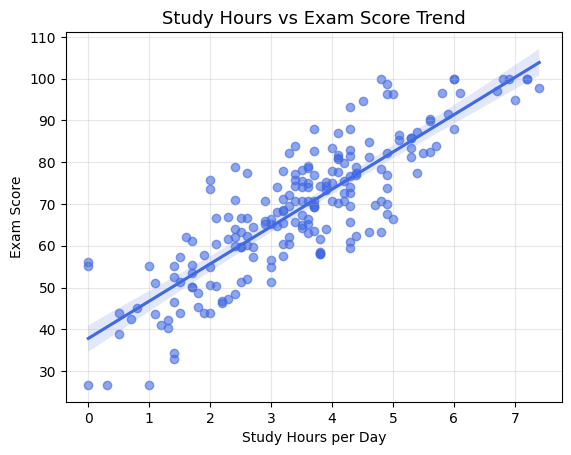

In [32]:
sns.regplot(x=df2['study_hours_per_day'], y=df2['exam_score'], color='royalblue', scatter_kws={'alpha':0.6})
plt.title('Study Hours vs Exam Score Trend', fontsize=13)
plt.xlabel('Study Hours per Day')
plt.ylabel('Exam Score')
plt.grid(alpha=0.3)
plt.show()


In [33]:
target = df['exam_score']

In [34]:
for col in num_cols:
    fig = px.box(
        df,
        x=col,
        points='all',  # shows all outliers
        title=f'Outlier Visualization: {col}',
        color_discrete_sequence=['#00CC96']
    )
    fig.update_layout(template='plotly_dark')
    fig.show()

In [35]:
df.drop(columns=['student_id'], inplace=True)

In [36]:
df_encoded = pd.get_dummies(df, drop_first=True)

In [37]:
df_encoded.head()

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,exercise_frequency,mental_health_rating,exam_score,gender_Male,gender_Other,part_time_job_Yes,diet_quality_Good,diet_quality_Poor,parental_education_level_High School,parental_education_level_Master,internet_quality_Good,internet_quality_Poor,extracurricular_participation_Yes
0,23,0.0,1.2,1.1,85.0,8.0,6,8,56.2,False,False,False,False,False,False,True,False,False,True
1,20,6.9,2.8,2.3,97.3,4.6,6,8,100.0,False,False,False,True,False,True,False,False,False,False
2,21,1.4,3.1,1.3,94.8,8.0,1,1,34.3,True,False,False,False,True,True,False,False,True,False
3,23,1.0,3.9,1.0,71.0,9.2,4,1,26.8,False,False,False,False,True,False,True,True,False,True
4,19,5.0,4.4,0.5,90.9,4.9,3,1,66.4,False,False,False,False,False,False,True,True,False,False


In [38]:
X = df_encoded.drop(columns=['exam_score'])
y = df_encoded['exam_score']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

In [40]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [41]:
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(random_state=69),
    'Lasso': Lasso(random_state=69),
    'RandomForest': RandomForestRegressor(n_estimators=200, random_state=69, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=200, random_state=69),
    'XGBoost': XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
}

In [42]:
from sklearn.model_selection import GridSearchCV

# Define models
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(random_state=69),
    'Lasso': Lasso(random_state=69),
    'RandomForest': RandomForestRegressor(random_state=69, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(random_state=69),
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=69)
}

# Define parameter grids
param_grids = {
    'LinearRegression': {'fit_intercept': [True, False]},
    'Ridge': {'alpha': [0.01, 0.1, 1, 10, 100], 'solver': ['auto', 'saga']},
    'Lasso': {'alpha': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [1000, 5000, 10000]},
    'RandomForest': {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]},
    'GradientBoosting': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 4, 5]},
    'XGBoost': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 4, 5],
                'subsample': [0.8, 1], 'colsample_bytree': [0.8, 1]}
}

# Tune hyperparameters
best_models = {}
for name, model in models.items():
    print(f"\n🔍 Tuning {name}...")
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='r2', n_jobs=-1, verbose=1)
    grid_search.fit(X_train_scaled, y_train)  # use scaled data if applicable
    print(f"✅ Best params for {name}: {grid_search.best_params_}")
    print(f"📈 Best R² score: {grid_search.best_score_:.4f}")
    best_models[name] = grid_search.best_estimator_

# Evaluate tuned models
results = {}
for name, model in best_models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

results_df = pd.DataFrame(results).T.sort_values(by='R2', ascending=False)
print("\nFinal Model Performance (after tuning):")
print(results_df)


🔍 Tuning LinearRegression...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
✅ Best params for LinearRegression: {'fit_intercept': True}
📈 Best R² score: 0.8964

🔍 Tuning Ridge...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
✅ Best params for Ridge: {'alpha': 1, 'solver': 'saga'}
📈 Best R² score: 0.8964

🔍 Tuning Lasso...
Fitting 5 folds for each of 15 candidates, totalling 75 fits
✅ Best params for LinearRegression: {'fit_intercept': True}
📈 Best R² score: 0.8964

🔍 Tuning Ridge...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
✅ Best params for Ridge: {'alpha': 1, 'solver': 'saga'}
📈 Best R² score: 0.8964

🔍 Tuning Lasso...
Fitting 5 folds for each of 15 candidates, totalling 75 fits
✅ Best params for Lasso: {'alpha': 0.1, 'max_iter': 1000}
📈 Best R² score: 0.8972

🔍 Tuning RandomForest...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
✅ Best params for Lasso: {'alpha': 0.1, 'max_iter': 1000}
📈 Best R² score: 0.8972

🔍 Tuning 

In [43]:
best_model_name = results_df.index[0]
best_model = best_models[best_model_name]

print(f"Best performing model: {best_model_name}")

Best performing model: Lasso


In [44]:
# saving the model
joblib.dump(best_model, 'exam_score_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [45]:
# load the model
loaded_model = joblib.load('exam_score_model.pkl')
scaler = joblib.load('scaler.pkl')

In [46]:
# scale and test model again for safety
X_test_scaled = scaler.transform(X_test)
y_pred = loaded_model.predict(X_test_scaled)

In [47]:
print("R² Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

R² Score: 0.8967561645059435
MAE: 4.427881562076517
